# SNUH - NVIDIA MONAI BootCamp - Auto3DdSeg 
 <img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>
 
by Hyungon Ryu | Sr. Solution Architect NVIDIA AI Tech. Center Korea (NVAITC Korea)

In this notebook, we will provide a simple demonstration of how to use Auto3DSeg AutoRunner to process a simulated dataset and generate results within minutes.

<img src="https://raw.githubusercontent.com/Project-MONAI/tutorials/main/auto3dseg/figures/workflow_v1.png" width="60%" />

## Overview

3D medical image segmentation is an important task with great potential for clinical understanding, disease diagnosis, and surgical planning. Auto3DSeg is a comprehensive solution for large-scale 3D medical image segmentation. It leverages the latest advances in MONAI and GPUs to efficiently develop and deploy algorithms with state-of-the-art performance for beginners or advanced researchers in the field. According to the statistics of the recent MICCAI conferences, more than 60% of the papers are applications of segmentation algorithms, and more than half of them use 3D datasets. After working in this field for many years, we have released the state-of-the-art segmentation solution Auto3DSeg, which requires minimal user input (e.g., data root and list).

Auto3DSeg first analyzes the global information, such as the dataset's intensity, data size, and data spacing. Then it generates algorithm folders in MONAI bundle format based on data statistics and algorithm templates. Next, all algorithms initiate model training to obtain checkpoints with the best validation accuracy. Finally, the ensemble module selects the algorithms via ranking trained checkpoints and creates ensemble predictions. Meanwhile, the solution offers different levels of user experience for beginners and advanced researchers. It has been tested on large-scale 3D medical imaging datasets in several different modalities.

- Unified Framework: Auto3DSeg is a self-contained 3D medical image segmentation solution with minimal user input.
- Flexible Modular Design: Auto3DSeg components can be used independently to meet different needs of users.
- Support of Bring-Your-Own-Algorithm (BYOA): We have introduced an efficient way to introduce users' own algorithms into the Auto3DSeg framework.
- High Accuracy and Efficiency: Auto3DSeg achieves state-of-the-art performance in most applications of 3D medical image segmentation.


### Table of Contents
* [Imports](#0.-Imports)
* [Dataset Setup](#1.-Dataset-Setup)
* [Auto3DSeg](#2.-Auto3DSeg)
* [Inspect Predictions](#3.-Inspect-Predictions)
* [Optional Exercises](#4.-Optional-Exercises)
* [Conclusion](#5.-Conclusion)

### System Setup

Before proceeding with the example, it is important to ensure that the NVIDIA driver has been installed correctly. You can verify this by running the nvidia-smi command, which should provide information about the GPUs on your system.

In [1]:
!nvidia-smi

Mon Aug 21 08:21:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                   On |
| N/A   31C    P0    52W / 400W |     39MiB / 81920MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:0F:00.0 Off |                   On |
| N/A   

### 0. Imports

In this notebook, we will only require minimal imports from MONAI and utilities, as Auto3DSeg will handle the remaining imports during its various phases.

#### 0.1 Installation
Before running the notebook, we need to ensure that the required packages are installed in the environment. You can install the necessary packages by running the following commands:

In [1]:
#!pip install -U monai-weekly[all]

#### 0.2 Imports

Let's import the required libraries and use the `print_config()` function to ensure that everything is installed correctly.

In [2]:
import os
import json
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from monai.apps.auto3dseg import AutoRunner
from monai.config import print_config
from monai.data import create_test_image_3d

print_config()

MONAI version: 1.3.dev2334
Numpy version: 1.22.2
Pytorch version: 1.14.0a0+44dac51
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c5771c7316c8b024071ecd7135d77ae70bcd557e
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 9.2.0
Tensorboard version: 2.9.0
gdown version: 4.7.1
TorchVision version: 0.15.0a0
tqdm version: 4.64.1
lmdb version: 1.4.1
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.1
transformers version: 4.21.3
mlflow version: 2.6.0
pynrrd version: 1.0.0
clearml version: 1.12.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### 1. Dataset Setup

#### 1.1 Simulate a Small Dataset

Training AI models can be time-consuming, so to provide a quick demonstration of Auto3DSeg in this notebook, we will simulate a small dataset and train the model for only a few epochs. Keep in mind that the performance of the trained model may not be optimal due to the limited training time, but the entire pipeline will be completed within minutes.

The `sim_datalist` variable contains information about the simulated datasets. It includes a list of 24 training images and corresponding labels, as well as 8 testing images and labels. The training data is divided into 2 folds, where each fold uses 12 images for training and 4 images for validation. The size of the dimensions can be defined by the `sim_dim` variable.

To proceed with the dataset setup, we will follow the steps below:

#### 1.2 Generate Images and Labels

We can utilize the `create_test_image_3d` function from MONAI and `nib.Nifti1Image` from the nibabel library to generate the 3D simulated images. These images will be saved under the specified `work_dir`.

Since we have already defined our image set, we can iterate over those images and label names to create matching files. In this case, our simulated data will consist of random circles generated in a 3D space, which we will visualize below.

In [1]:
import os
import json
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from monai.data import create_test_image_3d

Environment variable `TORCH_ALLOW_TF32_CUBLAS_OVERRIDE = 1` is set.
  This environment variable may enable TF32 mode accidentally and affect precision.
  See https://docs.monai.io/en/latest/precision_accelerating.html#precision-and-accelerating


In [3]:
def generate_dataset(data_root, num_train, num_test, sim_dim, num_seg_classes):
    sim_datalist = {
        "testing": [],
        "training": []
    }

    if not os.path.isdir(data_root):
        os.makedirs(data_root)

    for i in range(num_train):
        fold = i % 2  # Alternate between fold 0 and fold 1
        im, seg = create_test_image_3d(
            sim_dim[0], sim_dim[1], sim_dim[2], rad_max=10, num_seg_classes=num_seg_classes,
            random_state=np.random.RandomState(42 + i)
        )

        image_name = f"tr_image_{i:03d}.nii.gz"
        label_name = f"tr_label_{i:03d}.nii.gz"

        image_fpath = os.path.join(data_root, image_name)
        label_fpath = os.path.join(data_root, label_name)

        nib.save(nib.Nifti1Image(im, affine=np.eye(4)), image_fpath)
        nib.save(nib.Nifti1Image(seg, affine=np.eye(4)), label_fpath)

        entry = {"fold": fold, "image": image_name, "label": label_name}
        sim_datalist["training"].append(entry)

    for i in range(num_test):
        im, seg = create_test_image_3d(
            sim_dim[0], sim_dim[1], sim_dim[2], rad_max=10, num_seg_classes=num_seg_classes,
            random_state=np.random.RandomState(42 + num_train + i)
        )

        image_name = f"test_image_{i:03d}.nii.gz"
        label_name = f"test_label_{i:03d}.nii.gz"

        image_fpath = os.path.join(data_root, image_name)
        label_fpath = os.path.join(data_root, label_name)

        nib.save(nib.Nifti1Image(im, affine=np.eye(4)), image_fpath)
        nib.save(nib.Nifti1Image(seg, affine=np.eye(4)), label_fpath)

        entry = {"image": image_name, "label": label_name}
        sim_datalist["testing"].append(entry)

    datalist_file = os.path.join(data_root, "sim_datalist.json")
    with open(datalist_file, "w") as f:
        json.dump(sim_datalist, f)

    return datalist_file


In [4]:
# Define parameters
work_dir = "./auto3dseg"
num_train = 24
num_test = 8
sim_dim = (64, 64, 64)
num_seg_classes = 1

# Generate the dataset
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

dataroot_dir = os.path.join(work_dir, "sim_dataroot")
if not os.path.isdir(dataroot_dir):
    os.makedirs(dataroot_dir)



In [14]:
datalist_file = generate_dataset(dataroot_dir, num_train, num_test, sim_dim, num_seg_classes)
print("Generated dataset:", datalist_file)

Generated dataset: ./auto3dseg/sim_dataroot/sim_datalist.json


In [15]:
!cat  ./auto3dseg/sim_dataroot/sim_datalist.json

{"testing": [{"image": "test_image_000.nii.gz", "label": "test_label_000.nii.gz"}, {"image": "test_image_001.nii.gz", "label": "test_label_001.nii.gz"}, {"image": "test_image_002.nii.gz", "label": "test_label_002.nii.gz"}, {"image": "test_image_003.nii.gz", "label": "test_label_003.nii.gz"}, {"image": "test_image_004.nii.gz", "label": "test_label_004.nii.gz"}, {"image": "test_image_005.nii.gz", "label": "test_label_005.nii.gz"}, {"image": "test_image_006.nii.gz", "label": "test_label_006.nii.gz"}, {"image": "test_image_007.nii.gz", "label": "test_label_007.nii.gz"}], "training": [{"fold": 0, "image": "tr_image_000.nii.gz", "label": "tr_label_000.nii.gz"}, {"fold": 1, "image": "tr_image_001.nii.gz", "label": "tr_label_001.nii.gz"}, {"fold": 0, "image": "tr_image_002.nii.gz", "label": "tr_label_002.nii.gz"}, {"fold": 1, "image": "tr_image_003.nii.gz", "label": "tr_label_003.nii.gz"}, {"fold": 0, "image": "tr_image_004.nii.gz", "label": "tr_label_004.nii.gz"}, {"fold": 1, "image": "tr_ima

#### 1.3 Inspect the Simulated Data

To get an idea of the simulated images in the test dataset, we can select a slice from the 3D image and visualize it. This will give us a glimpse of the simulated data.

In [6]:
def visualize_dataset(dataroot_dir, dataset_type, index):
    with open(os.path.join(dataroot_dir, "sim_datalist.json"), "r") as f:
        sim_datalist = json.load(f)

    if dataset_type == "train":
        dataset = sim_datalist["training"]
    elif dataset_type == "test":
        dataset = sim_datalist["testing"]
    else:
        print("Invalid dataset type. Use 'train' or 'test'.")
        return

    if index < 0 or index >= len(dataset):
        print("Invalid index.")
        return

    entry = dataset[index]
    img_nib = nib.load(os.path.join(dataroot_dir, entry["image"]))
    lbl_nib = nib.load(os.path.join(dataroot_dir, entry["label"]))
    img = np.array(img_nib.dataobj)
    lbl = np.array(lbl_nib.dataobj)

    plt.subplot(1, 2, 1)
    plt.imshow(img[sim_dim[2] // 2])
    plt.title(f"Image - {dataset_type} idx {index}")
    cbar = plt.colorbar(shrink=0.55)

    plt.subplot(1, 2, 2)
    plt.imshow(lbl[sim_dim[2] // 2])
    plt.title(f"Label - {dataset_type} idx {index}")
    cbar = plt.colorbar(shrink=0.55)

    plt.tight_layout()
    plt.show()



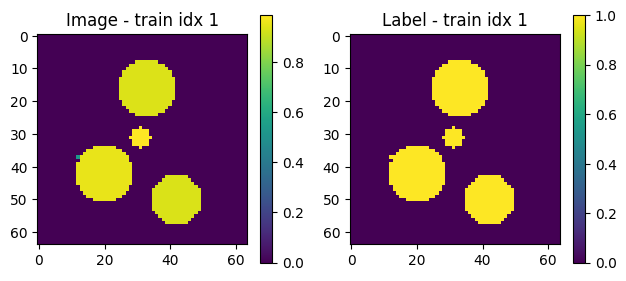

In [16]:
# Example usage
dataroot_dir = "./auto3dseg/sim_dataroot"
dataset_type = "train"  # or "test"
index = 1  # Specify the index you want to visualize

visualize_dataset(dataroot_dir, dataset_type, index)


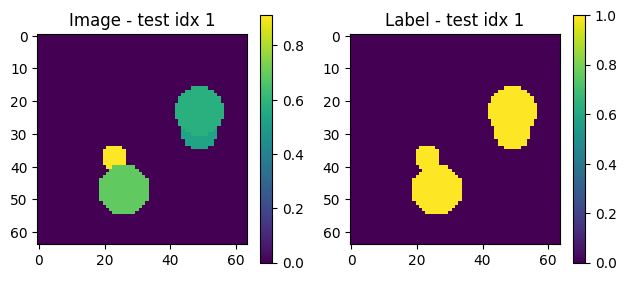

In [17]:
# Example usage
dataroot_dir = "./auto3dseg/sim_dataroot"
dataset_type = "test"  # or "test"
index = 1  # Specify the index you want to visualize

visualize_dataset(dataroot_dir, dataset_type, index)


#### 1.4 Data Analysis in Auto3DSeg

In this notebook, we will provide a brief example of how to to customize your data analysis pipeline

In [9]:
import os
import torch
import tempfile
import nibabel as nib
import numpy as np

from copy import deepcopy
from tqdm import tqdm

from monai.auto3dseg.analyzer import Analyzer
from monai.auto3dseg import (
    SampleOperations,
    SegSummarizer,
    concat_val_to_np,
    datafold_read,
)
from monai.config import print_config
from monai.data import DataLoader, Dataset, create_test_image_3d
from monai.data.utils import no_collation
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    Lambdad,
    LoadImaged,
    Orientationd,
    SqueezeDimd,
    ToDeviced,
)

from monai.utils.enums import DataStatsKeys


def _argmax_if_multichannel(x):
    return torch.argmax(x, dim=0, keepdim=True) if x.shape[0] > 1 else x


print_config()

MONAI version: 1.3.dev2334
Numpy version: 1.22.2
Pytorch version: 1.14.0a0+44dac51
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c5771c7316c8b024071ecd7135d77ae70bcd557e
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 9.2.0
Tensorboard version: 2.9.0
gdown version: 4.7.1
TorchVision version: 0.15.0a0
tqdm version: 4.64.1
lmdb version: 1.4.1
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.1
transformers version: 4.21.3
mlflow version: 2.6.0
pynrrd version: 1.0.0
clearml version: 1.12.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [10]:
class DimsAnalyzer(Analyzer):
    def __init__(self, image_key="image", stats_name="user_stats"):
        self.image_key = image_key
        report_format = {"ndims": None}
        super().__init__(stats_name, report_format)

    def __call__(self, data):
        d = dict(data)
        report = deepcopy(self.get_report_format())
        report["ndims"] = d[self.image_key].ndim
        d[self.stats_name] = report
        return d


class DimsSummaryAnalyzer(Analyzer):
    def __init__(self, stats_name="user_stats"):
        report_format = {"ndims": None}
        super().__init__(stats_name, report_format)
        self.update_ops("ndims", SampleOperations())

    def __call__(self, data):
        report = deepcopy(self.get_report_format())
        v_np = concat_val_to_np(data, [self.stats_name, "ndims"])
        report["ndims"] = self.ops["ndims"].evaluate(v_np)
        return report


In [11]:
# it has the three default analyzers (ImageStats, FgImageStats, LabelStats)
summarizer = SegSummarizer("image", "label")
summarizer.add_analyzer(DimsAnalyzer(), DimsSummaryAnalyzer())

In [12]:
def my_analyzer(datalist, dataroot, my_summarizer):
    keys = ["image", "label"]
    transform_list = [
        LoadImaged(keys=keys),
        EnsureChannelFirstd(keys=keys),  # this creates label to be (1,H,W,D)
        Orientationd(keys=keys, axcodes="RAS"),
        EnsureTyped(keys=keys, data_type="tensor"),
        Lambdad(keys="label", func=_argmax_if_multichannel),
        SqueezeDimd(keys=["label"], dim=0),
        ToDeviced(keys=keys, device="cuda" if torch.cuda.is_available() else "cpu"),
        my_summarizer,
    ]

    transform = Compose(transforms=list(filter(None, transform_list)))

    files, _ = datafold_read(datalist=datalist, basedir=dataroot, fold=-1)
    dataset = Dataset(data=files, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=no_collation)
    result = {DataStatsKeys.SUMMARY: {}, DataStatsKeys.BY_CASE: []}

    for batch_data in tqdm(dataloader):
        d = batch_data[0]
        stats_by_cases = {
            DataStatsKeys.BY_CASE_IMAGE_PATH: d[DataStatsKeys.BY_CASE_IMAGE_PATH],
            DataStatsKeys.BY_CASE_LABEL_PATH: d[DataStatsKeys.BY_CASE_LABEL_PATH],
            DataStatsKeys.IMAGE_STATS: d[DataStatsKeys.IMAGE_STATS],
            DataStatsKeys.FG_IMAGE_STATS: d[DataStatsKeys.FG_IMAGE_STATS],
            DataStatsKeys.LABEL_STATS: d[DataStatsKeys.LABEL_STATS],
            DataStatsKeys.IMAGE_HISTOGRAM: d[DataStatsKeys.IMAGE_HISTOGRAM],
            "user_stats": d["user_stats"],
        }

    result[DataStatsKeys.BY_CASE].append(stats_by_cases)
    result[DataStatsKeys.SUMMARY] = my_summarizer.summarize(result[DataStatsKeys.BY_CASE])
    return result

In [18]:
result = my_analyzer(datalist_file, dataroot_dir, summarizer)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
100%|██████████| 24/24 [00:07<00:00,  3.35it/s]


In [19]:
print(result[DataStatsKeys.BY_CASE][0]["user_stats"])

{'ndims': 4}


In [20]:
print(result[DataStatsKeys.SUMMARY]["user_stats"])

{'ndims': {'max': 4, 'mean': 4.0, 'median': 4.0, 'min': 4, 'stdev': 0.0, 'percentile': [4, 4, 4, 4], 'percentile_00_5': 4, 'percentile_10_0': 4, 'percentile_90_0': 4, 'percentile_99_5': 4}}


##### Add a new stat operation "sum"

In [21]:
op = SampleOperations()
# add a new operation
op.update({"sum": np.sum})


class NewDimsSummaryAnalyzer(Analyzer):
    def __init__(self, stats_name="user_stats"):
        report_format = {"ndims": None}
        super().__init__(stats_name, report_format)
        self.update_ops("ndims", op)

    def __call__(self, data):
        report = deepcopy(self.get_report_format())
        v_np = concat_val_to_np(data, [self.stats_name, "ndims"])
        report["ndims"] = self.ops["ndims"].evaluate(v_np)
        return report

In [22]:
summarizer = SegSummarizer("image", "label")
summarizer.add_analyzer(DimsAnalyzer(), NewDimsSummaryAnalyzer())
result = my_analyzer(datalist_file, dataroot_dir, summarizer)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
100%|██████████| 24/24 [00:00<00:00, 28.37it/s]


In [23]:
print(result[DataStatsKeys.SUMMARY]["user_stats"])

{'ndims': {'max': 4, 'mean': 4.0, 'median': 4.0, 'min': 4, 'stdev': 0.0, 'percentile': [4, 4, 4, 4], 'sum': 4, 'percentile_00_5': 4, 'percentile_10_0': 4, 'percentile_90_0': 4, 'percentile_99_5': 4}}


## 2. Auto3DSeg
#### 2.1 Using the Auto3DSeg AutoRunner Pipeline

The `AutoRunner` class provides an interface to run the Auto3DSeg pipeline. It offers high configurability and requires minimal user input to get started. The `AutoRunner` automatically configures multiple neural networks and performs multi-fold training to achieve state-of-the-art performance. In this example, we aim to complete the pipeline within two to four minutes, so we need to make some customizations.

Let's set up the `AutoRunner` with the following settings:

In [19]:
work_dir="./auto3dseg_1"
runner = AutoRunner(
    work_dir=work_dir,
    input={
        "modality": "MRI",
        "datalist": datalist_file,
        "dataroot": dataroot_dir,
    }
)

2023-08-21 08:25:56,128 - INFO - AutoRunner using work directory ./auto3dseg_1
2023-08-21 08:25:56,132 - INFO - Datalist was copied to work_dir: /workspace/notebook_monai/auto3dseg_1/sim_datalist.json
2023-08-21 08:25:56,133 - INFO - Setting num_fold 2 based on the input datalist /workspace/notebook_monai/auto3dseg_1/sim_datalist.json.
2023-08-21 08:25:56,136 - INFO - Using user defined command running prefix , will override other settings


#### 2.2 Override the Training Parameters

If you wish to use more than one GPU, you can modify the `CUDA_VISIBLE_DEVICES` environment variable or remove the key to utilize all available devices. However, please ensure that the number of GPUs is less than the number of partitions in the dataset to avoid any conflicts.

In this section, you can customize the settings for the `AutoRunner` to align with your specific use case. For this example, we will use smaller numbers to explore the functionality and utilization of Auto3DSeg. However, in real-world scenarios, you should adjust these numbers based on the dataset size, task difficulty, and the number of available GPUs.

In [20]:
max_epochs = 2

train_param = {
    "num_epochs_per_validation": 1,
    "num_images_per_batch": 2,
    "num_epochs": max_epochs,
    "num_warmup_epochs": 1,
}
runner.set_training_params(train_param)
runner.set_num_fold(num_fold=1)

#### 2.3 Starting the Auto3DSeg Pipeline

After setting the desired parameters, we can start the Auto3DSeg pipeline by using the `runner.run()` method. The `AutoRunner` will execute all the necessary steps to train the model.

Each module of Auto3DSeg can be used individually for different purposes, and the functions/methods within the components can be customized by users.

The Auto3DSeg pipeline consists of the following steps:

- Step 1: [Data Analyzer](https://github.com/Project-MONAI/tutorials/blob/main/auto3dseg/docs/data_analyzer.md)
- Step 2: [Algorithm Generation](https://github.com/Project-MONAI/tutorials/blob/main/auto3dseg/docs/algorithm_generation.md)
- Step 3: [Model Training, Validation, and Inference](https://github.com/Project-MONAI/tutorials/blob/main/auto3dseg/docs/bundle.md)
- Step 4 (Optional): [Hyper-parameter Optimization](https://github.com/Project-MONAI/tutorials/blob/main/auto3dseg/docs/hpo.md)
- Step 5: [Model Ensembling](https://github.com/Project-MONAI/tutorials/blob/main/auto3dseg/docs/ensemble.md)

In [21]:
runner.run()

2023-08-21 08:26:15,124 - INFO - Running data analysis...
2023-08-21 08:26:15,125 - INFO - Found 1 GPUs for data analyzing!


100%|██████████| 24/24 [00:01<00:00, 21.84it/s]


2023-08-21 08:26:16,292 - INFO - Writing data stats to /workspace/notebook_monai/auto3dseg_1/datastats.yaml.
2023-08-21 08:26:16,304 - INFO - Writing by-case data stats to /workspace/notebook_monai/auto3dseg_1/datastats_by_case.yaml, this may take a while.
2023-08-21 08:26:16,411 - INFO - BundleGen from https://github.com/Project-MONAI/research-contributions/releases/download/algo_templates/e01d67a.tar.gz


algo_templates.tar.gz: 96.0kB [00:00, 139kB/s]                             

2023-08-21 08:26:17,121 - INFO - Downloaded: /tmp/tmpgy8xmh7f/algo_templates.tar.gz
2023-08-21 08:26:17,121 - INFO - Expected md5 is None, skip md5 check for file /tmp/tmpgy8xmh7f/algo_templates.tar.gz.
2023-08-21 08:26:17,122 - INFO - Writing into directory: /workspace/notebook_monai/auto3dseg_1.


2023-08-21 08:26:17,458 - INFO - Generated:/workspace/notebook_monai/auto3dseg_1/dints_0
2023-08-21 08:26:17,529 - INFO - Generated:/workspace/notebook_monai/auto3dseg_1/segresnet_0
2023-08-21 08:26:17,557 - INFO - segresnet2d_0 is skipped! SegresNet2D is skipped due to median spacing of [1.0, 1.0, 1.0],  which means the dataset is not highly anisotropic, e.g. spacing[2] < 3*(spacing[0] + spacing[1])/2) .
2023-08-21 08:26:17,654 - INFO - Generated:/workspace/notebook_monai/auto3dseg_1/swinunetr_0
2023-08-21 08:26:17,696 - INFO - The keys num_warmup_epochs cannot be found in the /workspace/notebook_monai/auto3dseg_1/dints_0/configs/hyper_parameters.yaml for training. Skipped overriding key num_warmup_epochs.
2023-08-21 08:26:17,698 - INFO - ['python', '/workspace/notebook_monai/auto3dseg_1/dints_0/scripts/train.py', 'run', "--config_file='/workspace/notebook_monai/auto3dseg_1/dints_0/configs/hyper_parameters.yaml,/workspace/notebook_monai/auto3dseg_1/dints_0/configs/hyper_parameters_sea

Environment variable `TORCH_ALLOW_TF32_CUBLAS_OVERRIDE = 1` is set.
  This environment variable may enable TF32 mode accidentally and affect precision.
  See https://docs.monai.io/en/latest/precision_accelerating.html#precision-and-accelerating
This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
dints_0 - training ...: 100%|██████████| 2/2 [00:44<00:00, 22.18s/round]

dints_0 - validation at original spacing/resolution



2023-08-21 08:27:15,462 - WARNING - dints_0 - training: finished


2023-08-21 08:27:18,368 - INFO - ['python', '/workspace/notebook_monai/auto3dseg_1/segresnet_0/scripts/train.py', 'run', "--config_file='/workspace/notebook_monai/auto3dseg_1/segresnet_0/configs/hyper_parameters.yaml'", '--num_epochs_per_validation=1', '--num_images_per_batch=2', '--num_epochs=2', '--num_warmup_epochs=1']


Environment variable `TORCH_ALLOW_TF32_CUBLAS_OVERRIDE = 1` is set.
  This environment variable may enable TF32 mode accidentally and affect precision.
  See https://docs.monai.io/en/latest/precision_accelerating.html#precision-and-accelerating
segresnet_0 - training: 100%|██████████| 2/2 [00:13<00:00,  6.85s/epoch]


2023-08-21 08:27:41,480 - INFO - ['python', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/scripts/train.py', 'run', "--config_file='/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/hyper_parameters.yaml,/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/network.yaml,/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_infer.yaml,/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_train.yaml,/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_validate.yaml'", '--num_epochs_per_validation=1', '--num_images_per_batch=2', '--num_epochs=2', '--num_warmup_epochs=1']
config_file ['/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/hyper_parameters.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/network.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_infer.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_train.yaml', '/workspace/notebook_monai

Environment variable `TORCH_ALLOW_TF32_CUBLAS_OVERRIDE = 1` is set.
  This environment variable may enable TF32 mode accidentally and affect precision.
  See https://docs.monai.io/en/latest/precision_accelerating.html#precision-and-accelerating


2023-08-21 08:27:53,368 - INFO - Downloaded: /workspace/notebook_monai/auto3dseg_1/swinunetr_0/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt
2023-08-21 08:27:53,368 - INFO - Expected md5 is None, skip md5 check for file /workspace/notebook_monai/auto3dseg_1/swinunetr_0/pretrained_model/swin_unetr.base_5000ep_f48_lr2e-4_pretrained.pt.


This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
swinunetr_0 - training ...: 100%|██████████| 2/2 [00:22<00:00, 11.39s/round]
2023-08-21 08:28:18,942 - WARNING - swinunetr_0 - training: finished


2023-08-21 08:28:20,054 - INFO - Ensembling using single GPU!
2023-08-21 08:28:20,054 - INFO - The output_dir is not specified. /workspace/notebook_monai/auto3dseg_1/ensemble_output will be used to save ensemble predictions.
2023-08-21 08:28:20,055 - INFO - Directory /workspace/notebook_monai/auto3dseg_1/ensemble_output is created to save ensemble predictions
2023-08-21 08:28:20,091 - INFO - Auto3Dseg picked the following networks to ensemble:
2023-08-21 08:28:20,091 - INFO - swinunetr_0
2023-08-21 08:28:20,092 - INFO - Auto3Dseg ensemble prediction outputs will be saved in /workspace/notebook_monai/auto3dseg_1/ensemble_output.


Ensembling (rank 0)...:   0%|          | 0/8 [00:00<?, ?it/s]

config_file ['/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/hyper_parameters.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_infer.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_train.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_validate.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/network.yaml']
rank 0
image_save_func {'_target_': 'SaveImage', 'output_dir': '/workspace/notebook_monai/auto3dseg_1/ensemble_output', 'output_postfix': 'ensemble', 'output_dtype': '$np.uint8', 'resample': False, 'print_log': False, 'savepath_in_metadict': True, 'data_root_dir': './auto3dseg/sim_dataroot', 'separate_folder': False}


Ensembling (rank 0)...:  12%|█▎        | 1/8 [00:01<00:08,  1.22s/it]

config_file ['/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/hyper_parameters.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_infer.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_train.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_validate.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/network.yaml']
rank 0
image_save_func {'_target_': 'SaveImage', 'output_dir': '/workspace/notebook_monai/auto3dseg_1/ensemble_output', 'output_postfix': 'ensemble', 'output_dtype': '$np.uint8', 'resample': False, 'print_log': False, 'savepath_in_metadict': True, 'data_root_dir': './auto3dseg/sim_dataroot', 'separate_folder': False}


Ensembling (rank 0)...:  25%|██▌       | 2/8 [00:01<00:05,  1.09it/s]

config_file ['/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/hyper_parameters.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_infer.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_train.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_validate.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/network.yaml']
rank 0
image_save_func {'_target_': 'SaveImage', 'output_dir': '/workspace/notebook_monai/auto3dseg_1/ensemble_output', 'output_postfix': 'ensemble', 'output_dtype': '$np.uint8', 'resample': False, 'print_log': False, 'savepath_in_metadict': True, 'data_root_dir': './auto3dseg/sim_dataroot', 'separate_folder': False}


Ensembling (rank 0)...:  38%|███▊      | 3/8 [00:02<00:04,  1.23it/s]

config_file ['/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/hyper_parameters.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_infer.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_train.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_validate.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/network.yaml']
rank 0
image_save_func {'_target_': 'SaveImage', 'output_dir': '/workspace/notebook_monai/auto3dseg_1/ensemble_output', 'output_postfix': 'ensemble', 'output_dtype': '$np.uint8', 'resample': False, 'print_log': False, 'savepath_in_metadict': True, 'data_root_dir': './auto3dseg/sim_dataroot', 'separate_folder': False}


Ensembling (rank 0)...:  50%|█████     | 4/8 [00:03<00:03,  1.31it/s]

config_file ['/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/hyper_parameters.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_infer.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_train.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_validate.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/network.yaml']
rank 0
image_save_func {'_target_': 'SaveImage', 'output_dir': '/workspace/notebook_monai/auto3dseg_1/ensemble_output', 'output_postfix': 'ensemble', 'output_dtype': '$np.uint8', 'resample': False, 'print_log': False, 'savepath_in_metadict': True, 'data_root_dir': './auto3dseg/sim_dataroot', 'separate_folder': False}


Ensembling (rank 0)...:  62%|██████▎   | 5/8 [00:03<00:02,  1.35it/s]

config_file ['/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/hyper_parameters.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_infer.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_train.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_validate.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/network.yaml']
rank 0
image_save_func {'_target_': 'SaveImage', 'output_dir': '/workspace/notebook_monai/auto3dseg_1/ensemble_output', 'output_postfix': 'ensemble', 'output_dtype': '$np.uint8', 'resample': False, 'print_log': False, 'savepath_in_metadict': True, 'data_root_dir': './auto3dseg/sim_dataroot', 'separate_folder': False}


Ensembling (rank 0)...:  75%|███████▌  | 6/8 [00:04<00:01,  1.39it/s]

config_file ['/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/hyper_parameters.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_infer.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_train.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_validate.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/network.yaml']
rank 0
image_save_func {'_target_': 'SaveImage', 'output_dir': '/workspace/notebook_monai/auto3dseg_1/ensemble_output', 'output_postfix': 'ensemble', 'output_dtype': '$np.uint8', 'resample': False, 'print_log': False, 'savepath_in_metadict': True, 'data_root_dir': './auto3dseg/sim_dataroot', 'separate_folder': False}


Ensembling (rank 0)...:  88%|████████▊ | 7/8 [00:05<00:00,  1.40it/s]

config_file ['/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/hyper_parameters.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_infer.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_train.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/transforms_validate.yaml', '/workspace/notebook_monai/auto3dseg_1/swinunetr_0/configs/network.yaml']
rank 0
image_save_func {'_target_': 'SaveImage', 'output_dir': '/workspace/notebook_monai/auto3dseg_1/ensemble_output', 'output_postfix': 'ensemble', 'output_dtype': '$np.uint8', 'resample': False, 'print_log': False, 'savepath_in_metadict': True, 'data_root_dir': './auto3dseg/sim_dataroot', 'separate_folder': False}


Ensembling (rank 0)...: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]
2023-08-21 08:28:26,252 - INFO - Auto3Dseg pipeline is completed successfully.


## 3. Inspecting Predictions

Now that we have completed the Auto3DSeg pipeline and obtained the ensembled output, we can inspect the predictions and compare the results.

In [24]:
def visualize_inference(dataroot_dir, work_dir, datalist_file, sim_dim, index):
    with open(os.path.join(dataroot_dir, datalist_file), "r") as f:
        sim_datalist = json.load(f)

    dataset = sim_datalist["testing"]

    if index < 0 or index >= len(dataset):
        print("Invalid index.")
        return

    entry = dataset[index]
    image_name = entry["image"].split(".")[0]

    prediction_nib = nib.load(os.path.join(work_dir, "ensemble_output", image_name + "_ensemble" + ".nii.gz"))
    pred = np.array(prediction_nib.dataobj)

    img_nib = nib.load(os.path.join(dataroot_dir, entry["image"]))
    lbl_nib = nib.load(os.path.join(dataroot_dir, entry["label"]))
    img = np.array(img_nib.dataobj)
    lbl = np.array(lbl_nib.dataobj)

    # Display original image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img[sim_dim[2] // 2])
    plt.title("Original Image")
    plt.colorbar(shrink=0.55)

    # Display ground truth label
    plt.subplot(1, 3, 2)
    plt.imshow(lbl[sim_dim[2] // 2])
    plt.title("Ground Truth Label")
    plt.colorbar(shrink=0.55)

    # Display predicted label
    plt.subplot(1, 3, 3)
    if pred.ndim == 4:
        plt.imshow(pred[32, :, :, 1])
    else:
        plt.imshow(pred[32])
    plt.title("Predicted Label")
    plt.colorbar(shrink=0.55)

    plt.tight_layout()
    plt.show()



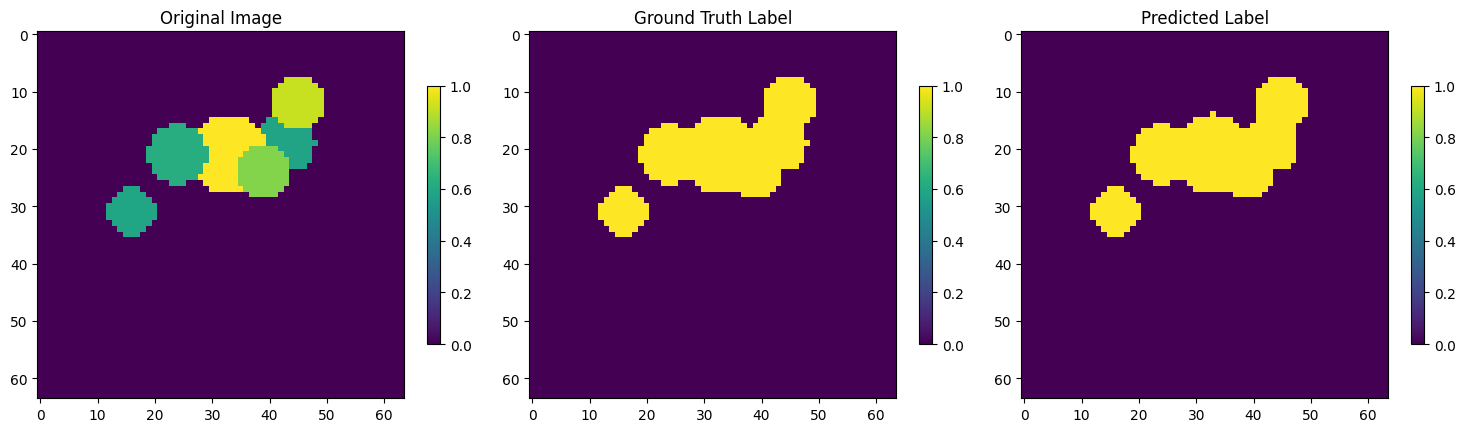

In [26]:
# Example usage
dataroot_dir = "./auto3dseg/sim_dataroot"
work_dir = "./auto3dseg_1"
visualize_inference(dataroot_dir, work_dir, "sim_datalist.json", sim_dim, index=3)

#### evaluate with more epoch

In [27]:
work_dir="./auto3dseg_2"
runner = AutoRunner(
    work_dir=work_dir,
    input={
        "modality": "MRI",
        "datalist": datalist_file,
        "dataroot": dataroot_dir,
    }
)

2023-08-21 08:45:11,622 - INFO - AutoRunner using work directory ./auto3dseg_2
2023-08-21 08:45:11,626 - INFO - Datalist was copied to work_dir: /workspace/notebook_monai/auto3dseg_2/sim_datalist.json
2023-08-21 08:45:11,627 - INFO - Setting num_fold 2 based on the input datalist /workspace/notebook_monai/auto3dseg_2/sim_datalist.json.
2023-08-21 08:45:11,630 - INFO - Using user defined command running prefix , will override other settings


In [28]:
max_epochs = 16

train_param = {
    "num_epochs_per_validation": 1,
    "num_images_per_batch": 4,
    "num_epochs": max_epochs,
    "num_warmup_epochs": 1,
}
runner.set_training_params(train_param)
runner.set_num_fold(num_fold=1)

In [ ]:
runner.run( )

#### compare train epoch 2 vs 16

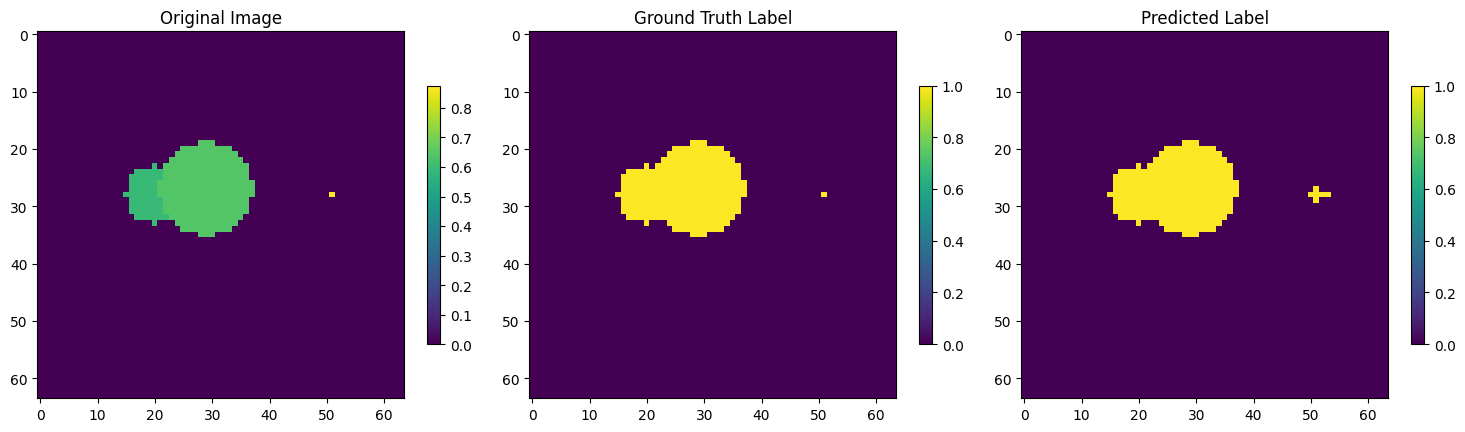

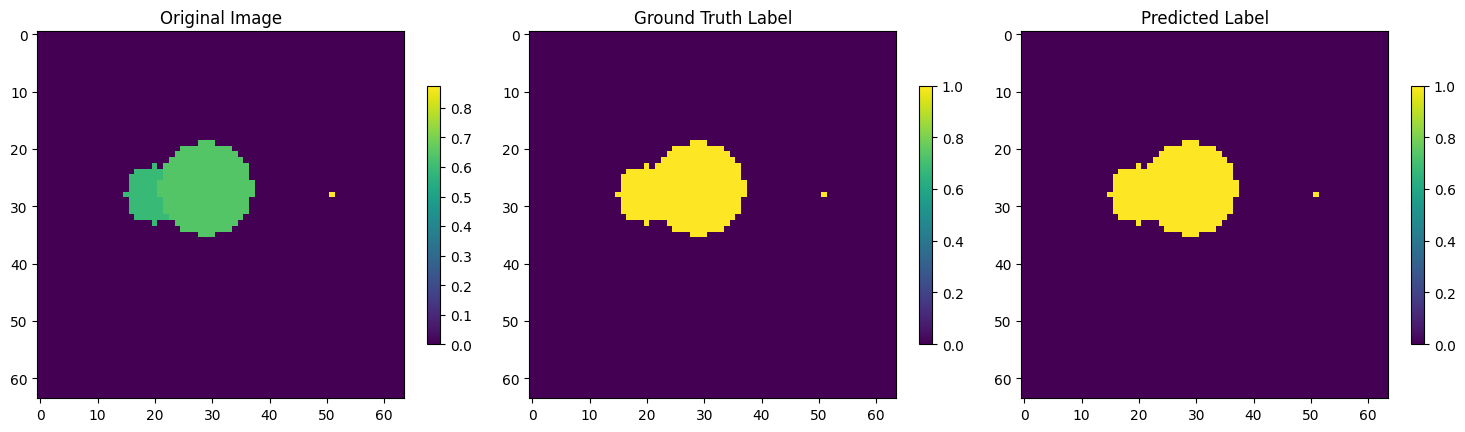

In [ ]:
# experiment with epoch 2
index=7 #  from 0 to 7
dataroot_dir = "./auto3dseg/sim_dataroot"
work_dir = "./auto3dseg_1"
visualize_inference(dataroot_dir, work_dir, "sim_datalist.json", sim_dim, index=index)
# experiment with epoch 16
work_dir = "./auto3dseg_2"
visualize_inference(dataroot_dir, work_dir, "sim_datalist.json", sim_dim, index=index)

#### modify parameters from  pretrained model

In [ ]:
!mkdir -p /content/auto3dseg_3
!cp -rf /content/auto3dseg_1/algorithm_templates /content/auto3dseg_3/.

#### edit config files
in auto3dseg_3

In [ ]:
work_dir="./auto3dseg_3"
runner = AutoRunner(
    work_dir=work_dir,
    input={
        "modality": "MRI",
        "datalist": datalist_file,
        "dataroot": dataroot_dir,
    }
)

2023-08-14 06:22:34,389 - INFO - AutoRunner using work directory ./helloworld_work_dir3
2023-08-14 06:22:34,392 - INFO - Datalist was copied to work_dir: /content/helloworld_work_dir3/sim_datalist.json
2023-08-14 06:22:34,396 - INFO - Setting num_fold 2 based on the input datalist /content/helloworld_work_dir3/sim_datalist.json.


In [ ]:
max_epochs = 4

train_param = {
    "num_epochs_per_validation": 1,
    "num_images_per_batch": 4,
    "num_epochs": max_epochs,
    "num_warmup_epochs": 1,
}
runner.set_training_params(train_param)
runner.set_num_fold(num_fold=1)

In [ ]:
runner.run()

In [ ]:
# experiment with epoch 2
index=7 #  from 0 to 7
dataroot_dir = "./auto3dseg/sim_dataroot"
work_dir = "./auto3dseg_1"
visualize_inference(dataroot_dir, work_dir, "sim_datalist.json", sim_dim, index=index)
# experiment with epoch 16
work_dir = "./auto3dseg_3"
visualize_inference(dataroot_dir, work_dir, "sim_datalist.json", sim_dim, index=index)

## 4. Optional Exercises
The optional exercises provide additional tasks for those who want to explore and go beyond the scope of the tutorial.

#### 4.1 Additional Algorithms and Longer Training
In our example above, we used training parameters to make sure that we could run the example in roughly two minutes.  However, you can experiment with different algorithms and longer training durations using the existing dataset.

As you explore more options, you'll notice the ability to customize various parameters depending on the algorithms. For example, the DiNTS network has two phases: a Search phase and a Train phase. You can independently modify the parameters for each of these sub-sections within DiNTS.

#### 4.2 Use a Real Dataset
In our "Hello World" example, we utilized a synthetic dataset to explore the functionalities of Auto3DSeg. However, the true benefits of Auto3DSeg can be seen when using it with real-world datasets.

We provide an additional notebook called `msd_datalist_generator.ipynb` in the sidebar, which can help generate the `datalist.json` for any of the Medical Segmentation Decathlon datasets. You can leverage MONAI's wrapper classes to retrieve any of the 10 different segmentation tasks from the Medical Segmentation Decathlon dataset and apply the power of Auto3DSeg to the task.


#### 4.3 Hyper-Parameter Optimization
We introduced some basic options for parameter selection in Auto3DSeg. However, you can further explore a more robust hyper-parameter optimization (HPO) experience by utilizing one of the supported third-party HPO packages.

We provide a base HPO generator class called `HPOGen`, which supports interactions between our algorithms and third-party HPO packages such as Microsoft Neural Network Intelligence (NNI) and Optuna.

You can refer to the following tutorials to explore HPO with Auto3DSeg:
- [NNI Tutorial](https://github.com/Project-MONAI/tutorials/blob/main/auto3dseg/notebooks/hpo_nni.ipynb)
- [Optuna Tutorial](https://github.com/Project-MONAI/tutorials/blob/main/auto3dseg/notebooks/hpo_optuna.ipynb)

#### 4.4 Implement Each Step of the Pipeline

In this notebook, we utilized the `AutoRunner` class to launch the Auto3DSeg pipeline. However, this class is just a wrapper for multiple internal API calls. You can explore calling each of these APIs and modifying additional parameters during each phase.

We provide a notebook called `auto3dseg_autorunner_ref_api.ipynb` that walks you through how to call each of the internal API functions within AutoRunner. This allows you to have more fine-grained control over the pipeline and customize parameters during each step.

Feel free to explore these optional exercises to further enhance your understanding and utilization of Auto3DSeg.

## 5. Conclusion
Congratulations! You have completed the entire Auto3DSeg pipeline. Throughout the process, you observed the algorithms learning from the dataset and generating predictions for both background and foreground voxels.

Auto3DSeg and AutoRunner offer high configurability, allowing you to customize various aspects of the pipeline. To improve your results, you can consider increasing the training time, exploring different ensemble methods, or utilizing hyper-parameter optimization through the AutoRunner or Auto3DSeg module APIs.

If you're interested in real-world use cases of Auto3DSeg, you can find more information and tutorials in the [Auto3DSeg Tutorials Folder](https://github.com/Project-MONAI/tutorials/tree/main/auto3dseg/).

Feel free to explore and experiment with Auto3DSeg to tackle your own 3D medical image segmentation tasks. Happy exploring!

## Navigation

- [01 MONAI transform](./01_getting.ipynb)
- [02_end_to_end_pipeline](./02_end_to_end_pipeline.ipynb)
- [03_spleen_segment](./03_spleen_segment.ipynb)
- [04_Auto3DSeg](./04_Auto3DSeg.ipynb)
- [05_Auto3DSeg_hippocampus](./05_Auto3DSeg_hippocampus.ipynb)
- [06_digital_pathology_wsi](./06_digital_pathology_wsi.ipynbb)
- [07_HoverNet_01_inference](./07_HoverNet_01_inference.ipynb)
- [08_HoverNet_02_train](./08_HoverNet_02_train.ipynb)



<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>